# Baseline vs. Mitigated Results Comparison

This notebook visualizes the comparison between the baseline recommender system results (`consolidated_results.csv`) and the results after applying a multiplicative damping mitigation strategy (`consolidated_mitigated_results.csv`).

**Goal:** Compare NDCG@10 and %ΔGAP across algorithms, evaluation strategies, user grouping methods, and user sub-groups (Niche vs. Blockbuster) to assess the mitigation's impact.

**Visualization:** Faceted Grouped Bar Charts. Each facet represents a user grouping method (`pop_one`, `pop_two`, `pop_four`). Within each facet, algorithms are on the x-axis. For each algorithm, bars are grouped to show Niche and Blockbuster users. Within these groups, bars compare evaluation strategies (`eva_two` vs. `eva_three`). Finally, for each strategy, paired bars show Baseline vs. Mitigated values.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

print("Libraries imported.")

Libraries imported.


## 1. Load and Prepare Data

In [2]:
# --- Configuration ---
BASELINE_CSV = 'consolidated_results.csv'
MITIGATED_CSV = 'consolidated_mitigated_results.csv'
TARGET_DOMAIN = 'music' # Options: 'music', 'movie'
# --- End Configuration ---

try:
    df_base = pd.read_csv(BASELINE_CSV)
    df_mitigated = pd.read_csv(MITIGATED_CSV)
except FileNotFoundError as e:
    print(f"Error loading CSV files: {e}")
    print("Please ensure both consolidated_results.csv and consolidated_mitigated_results.csv are in the same directory.")
    # Exit or raise error if files not found
    raise

# Add source column
df_base['source'] = 'Baseline'
df_mitigated['source'] = 'Mitigated'

# Combine data
df_combined = pd.concat([df_base, df_mitigated], ignore_index=True)

# Filter for the target domain
df_domain = df_combined[df_combined['domain'] == TARGET_DOMAIN].copy()

# Define user group mapping (handle pop_four inversion)
def map_user_group(row):
    pop_notion = row['popularity_notion']
    user_group = row['user_group']
    
    if user_group == 'med':
        return 'Diverse'
    
    if pop_notion == 'pop_four':
        if user_group == 'low':
            return 'Blockbuster (Low Niche Rate)'
        elif user_group == 'high':
            return 'Niche (High Niche Rate)'
    else: # pop_one and pop_two
        if user_group == 'low':
            return 'Niche'
        elif user_group == 'high':
            return 'Blockbuster'
    return None # Should not happen if data is clean

df_domain['display_group'] = df_domain.apply(map_user_group, axis=1)

# Filter out 'Diverse' group and comparison metrics (T-tests)
df_plot = df_domain[
    (df_domain['display_group'].isin(['Niche', 'Blockbuster', 'Niche (High Niche Rate)', 'Blockbuster (Low Niche Rate)'])) &
    (df_domain['metric_type'].isin(['NDCG', 'GAP']))
].copy()

# Rename metric_type GAP to %ΔGAP for clarity
df_plot['metric_type'] = df_plot['metric_type'].replace({'GAP': '%ΔGAP'})

# Ensure value is numeric
df_plot['value'] = pd.to_numeric(df_plot['value'], errors='coerce')

# Sort for consistent plotting order
algo_order = ['MostPop', 'UserKNN', 'ItemKNN', 'PMF', 'NMF', 'HPF'] # Ensure this matches your algo list
df_plot['algorithm'] = pd.Categorical(df_plot['algorithm'], categories=algo_order, ordered=True)
df_plot.sort_values(by=['popularity_notion', 'algorithm', 'display_group', 'evaluation_strategy', 'source'], inplace=True)

print(f"Data prepared for domain: {TARGET_DOMAIN}")
print(f"Total plot-relevant rows: {len(df_plot)}")
# print(df_plot[['popularity_notion', 'algorithm', 'display_group', 'evaluation_strategy', 'source', 'metric_type', 'value']].head())

Data prepared for domain: music
Total plot-relevant rows: 288


## 2. Define Plotting Function

In [3]:
def plot_faceted_comparison(data, metric, domain):
    """Generates the faceted comparison plot for a given metric and domain."""
    
    df_metric = data[data['metric_type'] == metric].copy()
    
    if df_metric.empty:
        print(f"No data found for metric '{metric}' in domain '{domain}'. Skipping plot.")
        return
        
    pop_notions = df_metric['popularity_notion'].unique()
    n_facets = len(pop_notions)
    algorithms = df_metric['algorithm'].cat.categories.tolist()
    n_algos = len(algorithms)

    # --- Define colors and hatches ---
    # Base colors for evaluation strategies
    strategy_colors = {
        'eva_two': sns.color_palette("Blues")[2],
        'eva_three': sns.color_palette("Oranges")[2]
    }
    # Slightly different look for mitigated bars (e.g., darker shade or hatch)
    mitigated_alpha = 0.7 # Make mitigated bars slightly more transparent
    # Alternatively use hatches:
    # baseline_hatch = ''
    # mitigated_hatch = '//'

    # Bar width and positions
    bar_width = 0.15
    group_gap = 0.1 # Gap between Niche/Blockbuster groups
    strategy_gap = 0.02 # Small gap between strategy pairs
    pair_gap = 0.01 # Small gap between baseline/mitigated within a pair
    
    # Calculate total width needed per algorithm group
    # (bar_width*2 + pair_gap)*2 (for strategies) + strategy_gap = width per user group
    # width_per_user_group * 2 + group_gap = total width per algorithm
    width_per_pair = bar_width * 2 + pair_gap
    width_per_strategy_group = width_per_pair * 2 + strategy_gap
    total_algo_width = width_per_strategy_group * 2 + group_gap
    
    x_indices = np.arange(n_algos)
    
    # --- Create Plot ---
    fig, axes = plt.subplots(1, n_facets, figsize=(7 * n_facets, 6), sharey=True)
    if n_facets == 1:
        axes = [axes] # Make it iterable if only one facet

    fig.suptitle(f'Baseline vs. Mitigated {metric} Comparison - Domain: {domain.capitalize()}', fontsize=16, y=1.02)

    handles = [] # For custom legend
    labels = []  # For custom legend

    for i, pop_notion in enumerate(pop_notions):
        ax = axes[i]
        df_facet = df_metric[df_metric['popularity_notion'] == pop_notion]
        
        # Define group names for this facet
        if pop_notion == 'pop_four':
            group1_name = 'Blockbuster (Low Niche Rate)' # Maps to 'low' in raw data
            group2_name = 'Niche (High Niche Rate)'      # Maps to 'high' in raw data
        else:
            group1_name = 'Niche' # Maps to 'low' in raw data
            group2_name = 'Blockbuster' # Maps to 'high' in raw data
            
        user_groups_ordered = [group1_name, group2_name]

        # Calculate bar positions for this facet
        pos_counter = 0
        bar_positions = {}
        start_offset = -total_algo_width / 2 + bar_width / 2

        current_pos = start_offset
        for ug_idx, user_group in enumerate(user_groups_ordered):
            for es_idx, eval_strategy in enumerate(['eva_two', 'eva_three']):
                 # Baseline bar position
                 bar_positions[(user_group, eval_strategy, 'Baseline')] = current_pos
                 current_pos += bar_width + pair_gap
                 # Mitigated bar position
                 bar_positions[(user_group, eval_strategy, 'Mitigated')] = current_pos
                 current_pos += bar_width 
                 if es_idx == 0: # Add strategy gap after eva_two pair
                     current_pos += strategy_gap
            if ug_idx == 0: # Add group gap after first user group
                 current_pos += group_gap

        # Draw bars
        for algo_idx, algorithm in enumerate(algorithms):
            for ug_idx, user_group in enumerate(user_groups_ordered):
                for es_idx, eval_strategy in enumerate(['eva_two', 'eva_three']):
                    
                    base_val = df_facet[
                        (df_facet['algorithm'] == algorithm) &
                        (df_facet['display_group'] == user_group) &
                        (df_facet['evaluation_strategy'] == eval_strategy) &
                        (df_facet['source'] == 'Baseline')
                    ]['value'].iloc[0] if not df_facet[
                        (df_facet['algorithm'] == algorithm) &
                        (df_facet['display_group'] == user_group) &
                        (df_facet['evaluation_strategy'] == eval_strategy) &
                        (df_facet['source'] == 'Baseline')
                    ].empty else 0
                    
                    miti_val = df_facet[
                        (df_facet['algorithm'] == algorithm) &
                        (df_facet['display_group'] == user_group) &
                        (df_facet['evaluation_strategy'] == eval_strategy) &
                        (df_facet['source'] == 'Mitigated')
                    ]['value'].iloc[0] if not df_facet[
                        (df_facet['algorithm'] == algorithm) &
                        (df_facet['display_group'] == user_group) &
                        (df_facet['evaluation_strategy'] == eval_strategy) &
                        (df_facet['source'] == 'Mitigated')
                    ].empty else 0

                    base_pos = x_indices[algo_idx] + bar_positions[(user_group, eval_strategy, 'Baseline')]
                    miti_pos = x_indices[algo_idx] + bar_positions[(user_group, eval_strategy, 'Mitigated')]
                    color = strategy_colors[eval_strategy]

                    ax.bar(base_pos, base_val, width=bar_width, color=color, edgecolor='black', linewidth=0.5, label=f"{eval_strategy}-Baseline" if algo_idx==0 and ug_idx==0 else "")
                    ax.bar(miti_pos, miti_val, width=bar_width, color=color, alpha=mitigated_alpha, hatch='//', edgecolor='grey', linewidth=0.5, label=f"{eval_strategy}-Mitigated" if algo_idx==0 and ug_idx==0 else "")

        # Customize facet
        ax.set_title(f"Grouping: {pop_notion}")
        ax.set_ylabel(metric) 
        ax.set_xlabel("Algorithm")
        ax.set_xticks(x_indices)
        ax.set_xticklabels(algorithms, rotation=45, ha='right')
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        ax.axhline(0, color='black', linewidth=0.5) # Add line at y=0 for reference

        # Add annotations for User Group context (optional, can get cluttered)
        # Position annotations between algorithm groups
        anno_y = ax.get_ylim()[0] # Place near bottom
        anno_offset = total_algo_width / 4 # Approx center of a user group block
        ax.text(x_indices[0] - anno_offset, anno_y, group1_name, ha='center', va='top', fontsize=9, rotation=90)
        ax.text(x_indices[0] + anno_offset, anno_y, group2_name, ha='center', va='top', fontsize=9, rotation=90)

    # --- Create Custom Legend ---
    legend_elements = []
    legend_labels = []
    
    # Evaluation strategy colors
    legend_elements.extend([mpatches.Patch(color=strategy_colors['eva_two'], label='UserTest (eva_two)'),
                          mpatches.Patch(color=strategy_colors['eva_three'], label='TrainItems (eva_three)')])
    legend_labels.extend(['UserTest (eva_two)', 'TrainItems (eva_three)'])

    # Baseline vs Mitigated markers
    legend_elements.extend([mpatches.Patch(facecolor='grey', edgecolor='black', label='Baseline'),
                          mpatches.Patch(facecolor='grey', alpha=mitigated_alpha, hatch='//', edgecolor='grey', label='Mitigated')])
    legend_labels.extend(['Baseline', 'Mitigated'])

    fig.legend(handles=legend_elements, labels=legend_labels, loc='upper center', bbox_to_anchor=(0.5, 0.98), ncol=4, fontsize=10)

    plt.tight_layout(rect=[0, 0, 1, 0.95]) # Adjust layout to prevent title overlap
    plt.show()

print("Plotting function defined.")

Plotting function defined.


## 3. Generate Plots


--- Generating NDCG Plot for Music ---


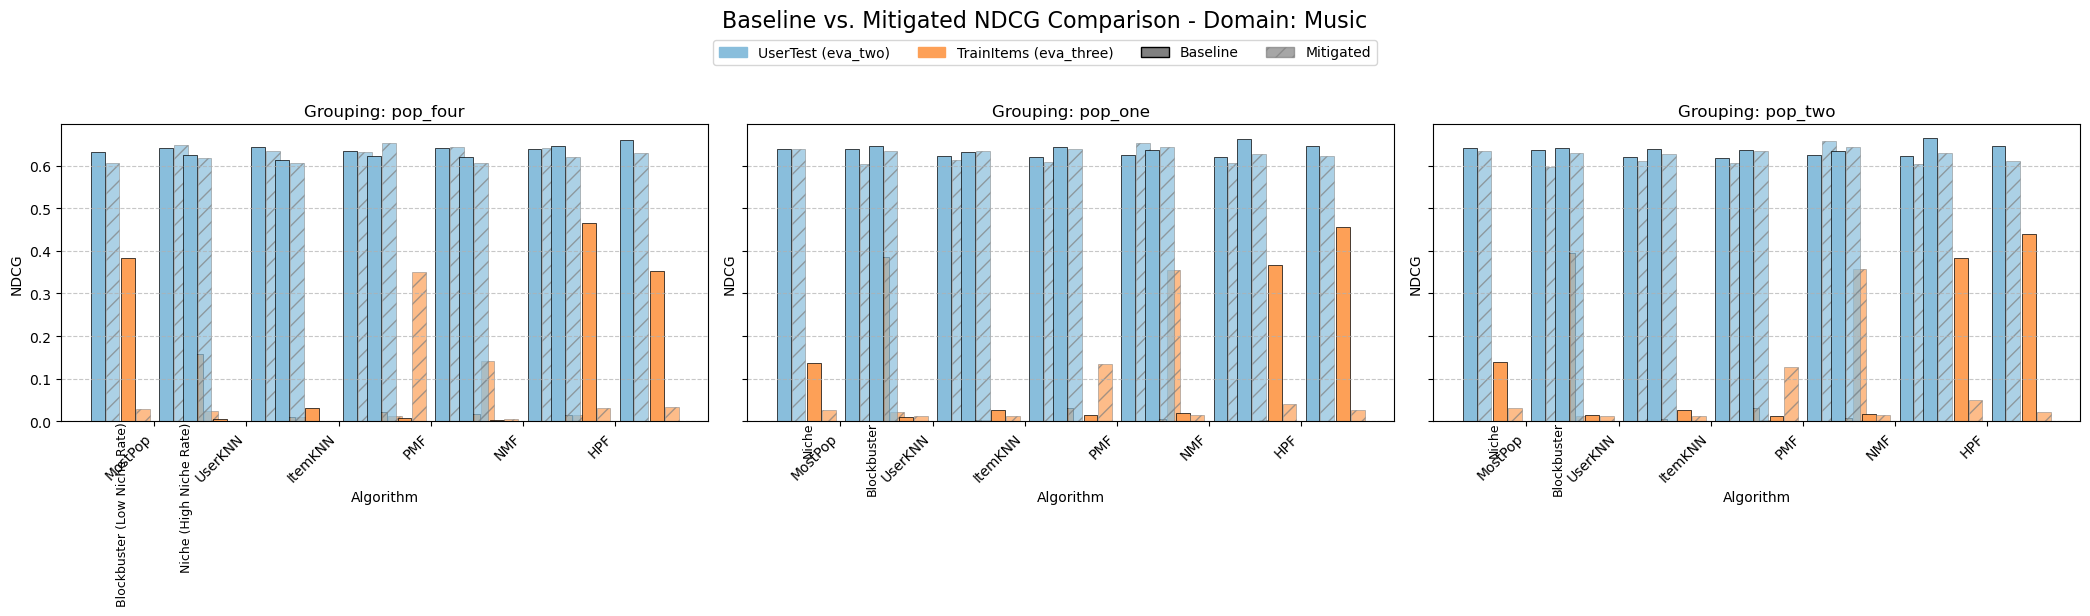

In [4]:
print(f"\n--- Generating NDCG Plot for {TARGET_DOMAIN.capitalize()} ---")
plot_faceted_comparison(df_plot, metric='NDCG', domain=TARGET_DOMAIN)


--- Generating %ΔGAP Plot for Music ---


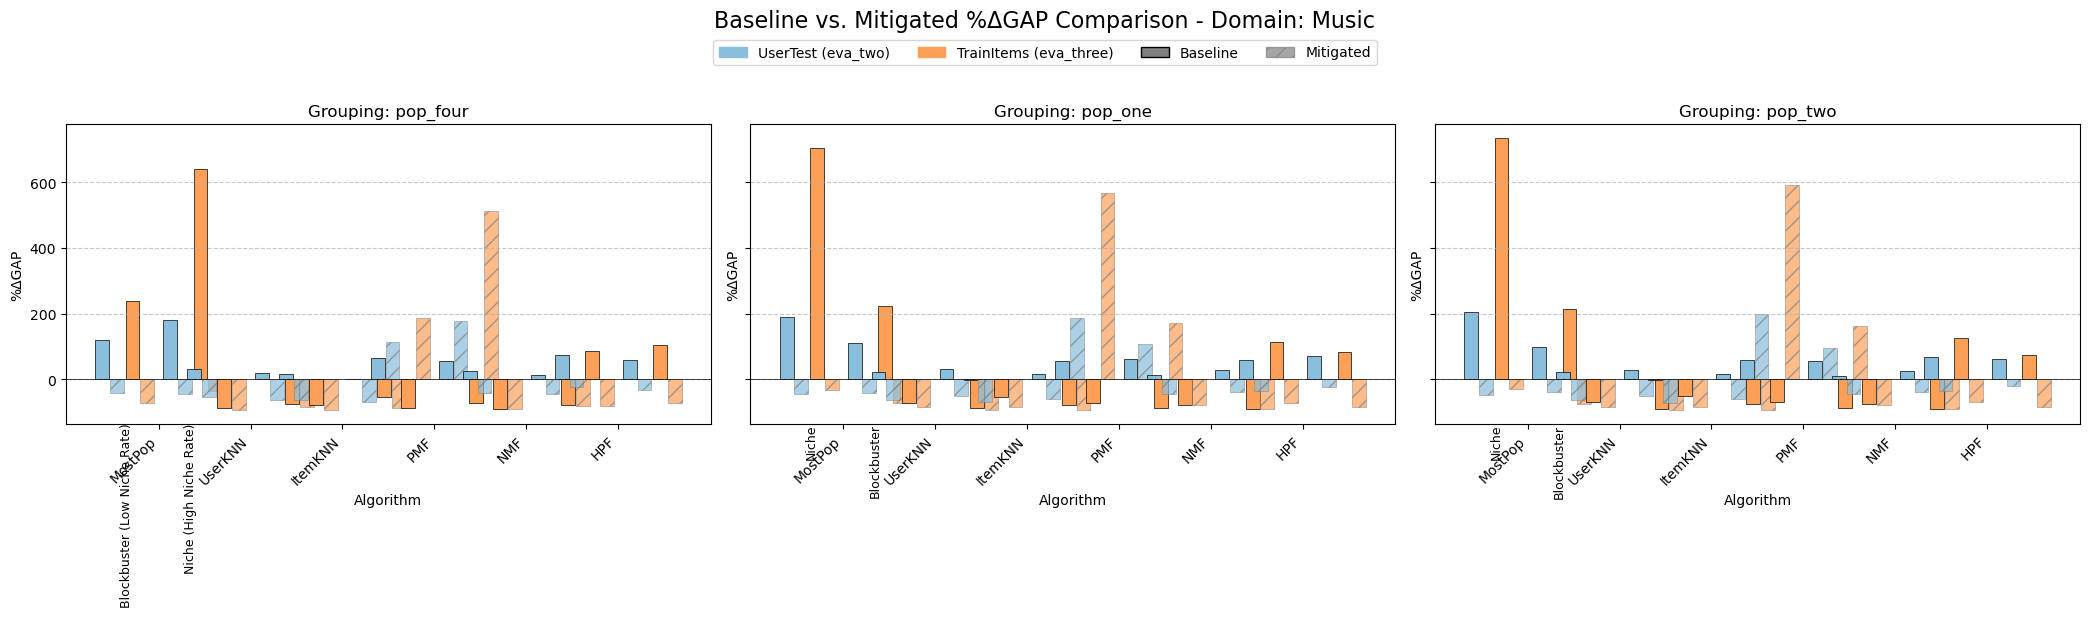

In [5]:
print(f"\n--- Generating %ΔGAP Plot for {TARGET_DOMAIN.capitalize()} ---")
plot_faceted_comparison(df_plot, metric='%ΔGAP', domain=TARGET_DOMAIN)